# CNN ECG Classification
Installing database and CD to the correct folders


In [ ]:
!pip install wfdb


In [ ]:
import os
os.listdir('/content')


['.config',
 'ecg_stft_cnn_best.h5',
 'drive',
 'best_ecg_model.keras',
 'sample_data']

In [ ]:
%cd /content/x_mitdb

[Errno 2] No such file or directory: '/content/x_mitdb'
/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save('/content/drive/MyDrive/ecg_cnn_model.keras')


Initialise band pass filter (butter)

In [ ]:
from scipy.signal import butter, filtfilt

def bandpass_filter(x, fs, low=0.5, high=40, order=4):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, x)


Load beats from multiple records for representative data

In [ ]:
import wfdb
import numpy as np

record_ids = [
    '100', '101', '102', '103', '105',
    '106', '108', '109', '111', '112',
    '114', '115', '116', '119',
    '200', '201', '202', '207', '210', '213'
]

beat_symbols = ['N', 'L', 'R', 'A', 'V', '!', 'E', 'F', 'j', 'e']

def extract_beats_from_record(record_id, window_before_sec=0.4, window_after_sec=0.6):
    """
    Extract bandpass-filtered beat segments and raw symbols from one MIT-BIH record.
    window_before_sec / window_after_sec are in seconds.
    """
    # Load ECG + annotations
    record = wfdb.rdrecord(record_id, pn_dir='mitdb')
    ann = wfdb.rdann(record_id, 'atr', pn_dir='mitdb')

    signal = record.p_signal[:, 0]  # lead 0 (usually MLII)
    fs = record.fs                 # typically 360 Hz

    signal_filt = bandpass_filter(signal, fs)

    r_locs = ann.sample
    symbols = ann.symbol

    # Convert window from seconds to samples
    window_before = int(window_before_sec * fs)
    window_after  = int(window_after_sec * fs)
    segment_len = window_before + window_after

    segments = []
    labels_raw = []

    for r, sym in zip(r_locs, symbols):
        if sym not in beat_symbols:
            continue

        start = r - window_before
        end   = r + window_after

        if start < 0 or end > len(signal_filt):
            continue

        seg = signal_filt[start:end]
        if len(seg) != segment_len:
            continue

        segments.append(seg)
        labels_raw.append(sym)

    segments = np.array(segments)
    labels_raw = np.array(labels_raw)

    print(f"Record {record_id}: kept {len(labels_raw)} beats")
    return segments, labels_raw

all_segments = []
all_labels_raw = []
all_record_of_beat = []   # NEW

for rid in record_ids:
    segs, labs = extract_beats_from_record(rid)
    if len(labs) == 0:
        continue
    all_segments.append(segs)
    all_labels_raw.append(labs)
    all_record_of_beat += [rid] * len(labs)   # NEW

segments = np.vstack(all_segments)
labels_raw = np.concatenate(all_labels_raw)
record_of_beat = np.array(all_record_of_beat)  # NEW


print("TOTAL beats from all records:", segments.shape[0])
print("Segment length:", segments.shape[1])
print("First 10 labels:", labels_raw[:10])


Record 100: kept 2271 beats
Record 101: kept 1862 beats
Record 102: kept 103 beats
Record 103: kept 2083 beats
Record 105: kept 2567 beats
Record 106: kept 2026 beats
Record 108: kept 1762 beats
Record 109: kept 2530 beats
Record 111: kept 2124 beats
Record 112: kept 2537 beats
Record 114: kept 1877 beats
Record 115: kept 1952 beats
Record 116: kept 2411 beats
Record 119: kept 1986 beats
Record 200: kept 2600 beats
Record 201: kept 1864 beats
Record 202: kept 2116 beats
Record 207: kept 2330 beats
Record 210: kept 2626 beats
Record 213: kept 3245 beats
TOTAL beats from all records: 42872
Segment length: 360
First 10 labels: ['N' 'N' 'N' 'N' 'N' 'N' 'A' 'N' 'N' 'N']


In [ ]:
print("labels_raw length:", len(labels_raw))
print("record_of_beat length:", len(record_of_beat))
assert len(labels_raw) == len(record_of_beat) == segments.shape[0]


labels_raw length: 42872
record_of_beat length: 42872


In [ ]:
NORMAL_BEATS = {'N', 'L', 'R', 'e', 'j'}

labels = np.array([
    0 if sym in NORMAL_BEATS else 1
    for sym in labels_raw
])
y = labels.astype(np.int32)


Build the spectrogram for each beat with the short time fourier transform to a standard 64x64 size

In [ ]:
from scipy.signal import stft
import cv2
import numpy as np

fs = 360
nperseg = 64
noverlap = 32

specs = []

print("Building spectrograms for", len(segments), "beats...")

for i, beat in enumerate(segments):
    f, t, Zxx = stft(beat, fs=fs, nperseg=nperseg, noverlap=noverlap)
    S = np.abs(Zxx)

    S_resized = cv2.resize(S, (64, 64), interpolation=cv2.INTER_AREA)
    S_resized = np.log1p(S_resized)
    S_resized = (S_resized - S_resized.mean()) / (S_resized.std() + 1e-8)

    specs.append(S_resized.astype(np.float32))

X = np.array(specs, dtype=np.float32)[..., np.newaxis]
y = labels.astype(int)

print("DONE.")
print("X shape:", X.shape)
print("y shape:", y.shape)


Building spectrograms for 42872 beats...
DONE.
X shape: (42872, 64, 64, 1)
y shape: (42872,)


Partition dataset into train/val/test

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

unique_records = np.unique(record_of_beat)

train_records, test_records = train_test_split(unique_records, test_size=0.2, random_state=42)
train_records, val_records  = train_test_split(train_records, test_size=0.2, random_state=42)

train_mask = np.isin(record_of_beat, train_records)
val_mask   = np.isin(record_of_beat, val_records)
test_mask  = np.isin(record_of_beat, test_records)

train_rec = set(np.unique(record_of_beat[train_mask]))
val_rec   = set(np.unique(record_of_beat[val_mask]))
test_rec  = set(np.unique(record_of_beat[test_mask]))

print("Overlap train∩val:", len(train_rec & val_rec))
print("Overlap train∩test:", len(train_rec & test_rec))
print("Overlap val∩test:", len(val_rec & test_rec))


segments_train = segments[train_mask]
segments_val   = segments[val_mask]
segments_test  = segments[test_mask]

labels_train_raw = labels_raw[train_mask]
labels_val_raw   = labels_raw[val_mask]
labels_test_raw  = labels_raw[test_mask]


Overlap train∩val: 0
Overlap train∩test: 0
Overlap val∩test: 0


In [ ]:
normal_syms = {'N','L','R','e','j'}

y_train = np.array([0 if s in normal_syms else 1 for s in labels_train_raw], dtype=int)
y_test  = np.array([0 if s in normal_syms else 1 for s in labels_test_raw],  dtype=int)

print("Train class counts [0,1]:", np.bincount(y_train))
print("Test class counts  [0,1]:", np.bincount(y_test))


Train class counts [0,1]: [24144  1535]
Test class counts  [0,1]: [7272 1055]


In [ ]:
import collections
symbol_counts = collections.Counter(labels_raw)
symbol_counts


Counter({np.str_('N'): 32681,
         np.str_('A'): 282,
         np.str_('V'): 2780,
         np.str_('F'): 385,
         np.str_('j'): 11,
         np.str_('L'): 6070,
         np.str_('R'): 85,
         np.str_('!'): 472,
         np.str_('E'): 106})

In [ ]:
print("Train bincount:", np.bincount(y_train))
print("Val bincount:", np.bincount(y_val))
print("Test bincount:", np.bincount(y_test))


Train bincount: [24144  1535]
Val bincount: [5827  604]
Test bincount: [7272 1055]


Buid the CNN architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

model = models.Sequential([
    layers.Input(shape=(64, 64, 1)),
    layers.Conv2D(16, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')   # <- binary
])



model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,569 (1.09 MB)

 Trainable params: 285,569 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("y_train unique:", np.unique(y_train))
print("y_test unique:", np.unique(y_test))


y_train unique: [0 1]
y_test unique: [0 1]


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='roc_auc'),
        tf.keras.metrics.AUC(name='pr_auc', curve='PR')
    ]
)


In [ ]:
print("Train class balance:", np.mean(y_train))
print("Val class balance:", np.mean(y_val))


Train class balance: 0.059776471046380314
Val class balance: 0.09392007463846991


MOdel Training and evaluation

In [ ]:
cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_pr_auc',
    mode='max',
    patience=2,
    restore_best_weights=True
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    shuffle=True,
    callbacks=[cb]
)

Epoch 1/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 66s 159ms/step - accuracy: 0.9082 - loss: 0.3910 - pr_auc: 0.0591 - roc_auc: 0.5058 - val_accuracy: 0.9061 - val_loss: 0.5303 - val_pr_auc: 0.4641 - val_roc_auc: 0.7172
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 64s 159ms/step - accuracy: 0.9402 - loss: 0.2744 - pr_auc: 0.1366 - roc_auc: 0.6940 - val_accuracy: 0.9061 - val_loss: 0.5732 - val_pr_auc: 0.3017 - val_roc_auc: 0.7756
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 82s 158ms/step - accuracy: 0.9402 - loss: 0.2394 - pr_auc: 0.5219 - roc_auc: 0.8831 - val_accuracy: 0.8000 - val_loss: 0.6525 - val_pr_auc: 0.1715 - val_roc_auc: 0.6744


Save to/Import from Google Drive


In [ ]:
model.save("best_ecg_model.keras")


Training metrics and performance data

In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

y_val_scores = model.predict(X_val, verbose=0).ravel()
prec, rec, thr = precision_recall_curve(y_val, y_val_scores)

# Align: use prec[1:], rec[1:] with thr
f1 = 2 * prec[1:] * rec[1:] / (prec[1:] + rec[1:] + 1e-8)
best_thresh = thr[np.argmax(f1)]
print("best_thresh:", best_thresh)


best_thresh: 0.40031645


In [ ]:
y_test_scores = model.predict(X_test, verbose=0).ravel()
print("min/max test scores:", y_test_scores.min(), y_test_scores.max())
print("fraction >= 0.5:", np.mean(y_test_scores >= 0.5))
print("fraction >= best_thresh:", np.mean(y_test_scores >= best_thresh))


min/max test scores: 0.037994467 0.16282722
fraction >= 0.5: 0.0
fraction >= best_thresh: 0.0


In [ ]:
y_test_scores = model.predict(X_test).ravel()
y_pred = (y_test_scores >= best_thresh).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step
[[7272    0]
 [1055    0]]
              precision    recall  f1-score   support

           0     0.8733    1.0000    0.9324      7272
           1     0.0000    0.0000    0.0000      1055

    accuracy                         0.8733      8327
   macro avg     0.4367    0.5000    0.4662      8327
weighted avg     0.7627    0.8733    0.8142      8327



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


dict_keys(['accuracy', 'loss', 'pr_auc', 'roc_auc', 'val_accuracy', 'val_loss', 'val_pr_auc', 'val_roc_auc'])


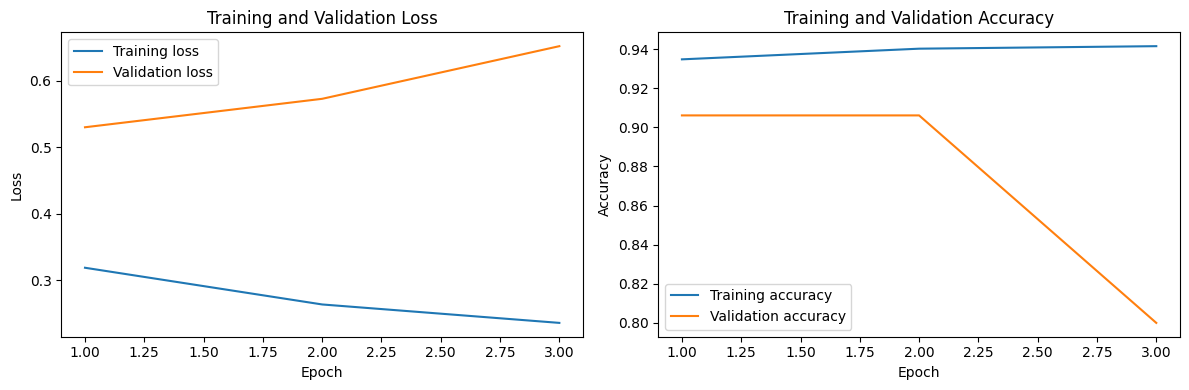

In [ ]:
import matplotlib.pyplot as plt

# Extract history
history_dict = history.history
print(history_dict.keys())

if 'accuracy' in history_dict:
    acc_key = 'accuracy'
    val_acc_key = 'val_accuracy'
else:
    acc_key = 'acc'
    val_acc_key = 'val_acc'

loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict[acc_key]
val_acc = history_dict[val_acc_key]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12,4))

# ---- Loss ----
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# ---- Accuracy ----
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Example beats and spectrograms

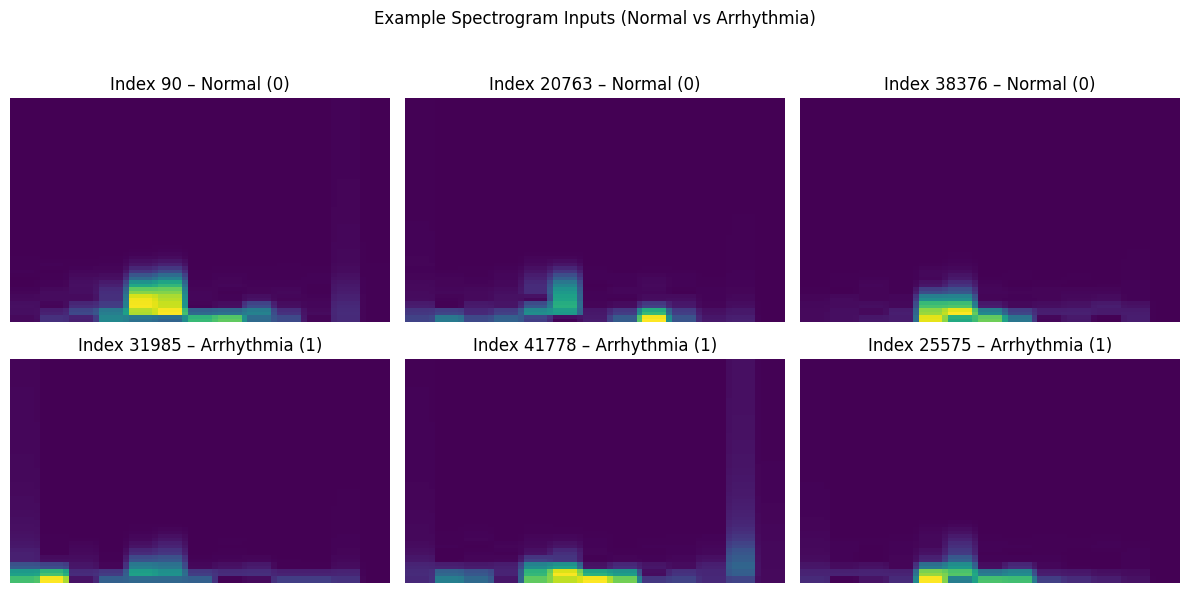

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Make sure X and y are numpy arrays
X_arr = np.array(X)
y_arr = np.array(y)

# Indices of each class
normal_idx = np.where(y_arr == 0)[0]
arr_idx    = np.where(y_arr == 1)[0]

# Pick up to 3 of each
num_show = 3
normal_samples = np.random.choice(normal_idx, size=min(num_show, len(normal_idx)), replace=False)
arr_samples    = np.random.choice(arr_idx, size=min(num_show, len(arr_idx)), replace=False)

indices = np.concatenate([normal_samples, arr_samples])

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    plt.subplot(2, 3, i+1)
    img = X_arr[idx].squeeze()  # (64, 64)
    plt.imshow(img, aspect='auto', origin='lower')
    label = 'Normal (0)' if y_arr[idx] == 0 else 'Arrhythmia (1)'
    plt.title(f"Index {idx} – {label}")
    plt.axis('off')

plt.suptitle("Example Spectrogram Inputs (Normal vs Arrhythmia)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


normal example:


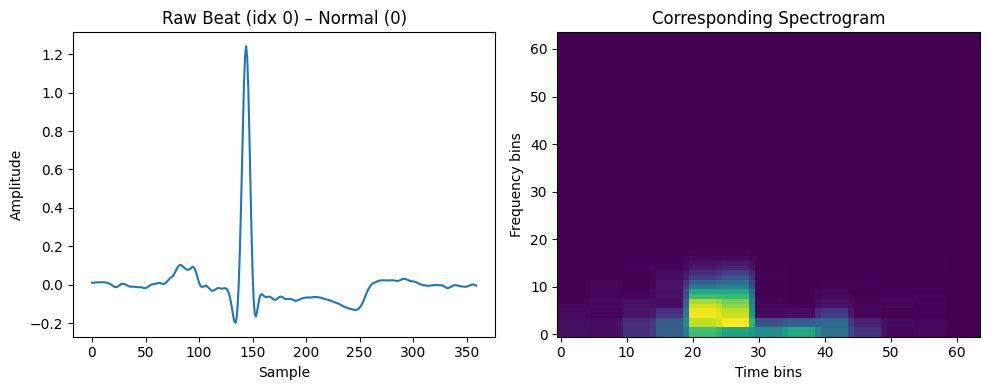

arrhythmia example:


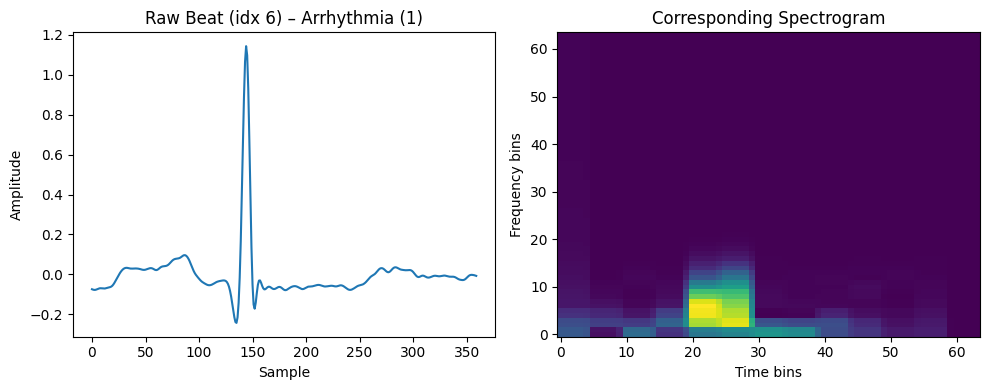

In [ ]:
import matplotlib.pyplot as plt

def plot_beat_and_spectrogram(idx):
    beat = segments[idx]            # 1-D signal
    spec = X_arr[idx].squeeze()     # 2-D spectrogram (64x64)
    label = 'Normal (0)' if y_arr[idx] == 0 else 'Arrhythmia (1)'

    plt.figure(figsize=(10,4))

    # Raw beat
    plt.subplot(1, 2, 1)
    plt.plot(beat)
    plt.title(f"Raw Beat (idx {idx}) – {label}")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")

    # Spectrogram
    plt.subplot(1, 2, 2)
    plt.imshow(spec, aspect='auto', origin='lower')
    plt.title("Corresponding Spectrogram")
    plt.xlabel("Time bins")
    plt.ylabel("Frequency bins")

    plt.tight_layout()
    plt.show()

print("normal example:")
normal_example = int(normal_idx[0])
plot_beat_and_spectrogram(normal_example)

print("arrhythmia example:")
arr_example = int(arr_idx[0])
plot_beat_and_spectrogram(arr_example)
